<a href="https://colab.research.google.com/github/TiagoBruno00/Redes_Neuronales/blob/C%C3%B3digo/1_1_Clasificador_Consigna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
# Comprobación de disponibilidad de GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


In [ ]:
# 1. Descargar y preparar los datos
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),])

train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
valid_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 2. Definición del Clasificador
class Clasificador(nn.Module):
    def __init__(self, hidden_size=10, dropout_rate=0.8):
        super(Clasificador, self).__init__()

        self.encoder_clasificador = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            #nn.Dropout(dropout_rate),  # Sin Dropout1
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            #nn.Dropout(dropout_rate),  # Sin Dropout2
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Dropout(dropout_rate),   # Dropout3
            nn.Linear(32 * 5 * 5, hidden_size), # fc
            nn.ReLU(),
        )

        # Clasificador
        self.clasificar = nn.Linear(hidden_size, 10)


    def forward(self, x):
        x = self.encoder_clasificador(x)
        x = self.clasificar(x)

        return x

In [ ]:
# 3. Inicialización con encoder entrenado

# Cargar los pesos del autoencoder
ruta = '/content/pesos_autoencoder_consigna.pth'
pesos_autoencoder = torch.load(ruta)

# Inicializar el clasificador con los pesos del encoder del autoencoder
clasificador = Clasificador(hidden_size=10, dropout_rate=0.8)

# Copiar los pesos del encoder del autoencoder al encoder del clasificador
for name, param in pesos_autoencoder.items():
    if name.startswith('encoder'):
        new_name = name.replace('encoder', 'encoder_clasificador')
        if new_name in clasificador.state_dict():
            clasificador.state_dict()[new_name].copy_(param.data)

# Inicializar el clasificador con los pesos del encoder
#clasificador = Clasificador(hidden_size=10, dropout_rate=0.8)
clasificador.load_state_dict(pesos_encoder, strict=False) # Cargar solo los pesos del encoder
clasificador.to(device)

# Definir el criterio de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
# Crear un optimizador solo para los parámetros de la última capa del clasificador
optimizer = torch.optim.Adam(clasificador.clasificar.parameters(), lr=learning_rate)

In [ ]:
# 4. Entrenamiento y Validación

# Entrenamiento
def train(loader, model, optimizer, criterion):
    model.train()
    train_loss = 0.0
    for inputs, labels in loader:
        inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
        labels = labels.to(device)  # Mover las etiquetas al dispositivo adecuado
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)


# Función de precisión (accuracy)
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


# Validación
def validate(loader, model, criterion):
    model.eval()
    valid_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
            labels = labels.to(device)  # Mover las etiquetas al dispositivo adecuado
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            correct_predictions += compute_accuracy(outputs, labels) * labels.size(0)
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return valid_loss / len(loader), accuracy

# Uso de las funciones de entrenamiento y validación
num_epochs = 40
train_losses_incorrecto = []  # Error de entrenamiento sin modo evaluación
train_losses = []  # Error de entrenamiento con modo evaluación
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss_incorrecto = train(train_loader, clasificador, optimizer, criterion)
    train_loss, train_acc = validate(train_loader, clasificador, criterion)  # Error de entrenamiento con modo evaluación
    test_loss, test_acc = validate(valid_loader, clasificador, criterion)
    train_losses_incorrecto.append(train_loss_incorrecto)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Imprimir progreso
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {test_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch [1/50], Train Loss: 0.5520, Valid Loss: 0.5670
Epoch [1/50], Train Accuracy: 0.7878, Test Accuracy: 0.7817
Epoch [2/50], Train Loss: 0.4969, Valid Loss: 0.5139
Epoch [2/50], Train Accuracy: 0.8068, Test Accuracy: 0.8002
Epoch [3/50], Train Loss: 0.4576, Valid Loss: 0.4782
Epoch [3/50], Train Accuracy: 0.8384, Test Accuracy: 0.8291
Epoch [4/50], Train Loss: 0.4339, Valid Loss: 0.4545
Epoch [4/50], Train Accuracy: 0.8423, Test Accuracy: 0.8332
Epoch [5/50], Train Loss: 0.4176, Valid Loss: 0.4399
Epoch [5/50], Train Accuracy: 0.8526, Test Accuracy: 0.8426
Epoch [6/50], Train Loss: 0.4000, Valid Loss: 0.4214
Epoch [6/50], Train Accuracy: 0.8561, Test Accuracy: 0.8453
Epoch [7/50], Train Loss: 0.3804, Valid Loss: 0.4035
Epoch [7/50], Train Accuracy: 0.8651, Test Accuracy: 0.8558
Epoch [8/50], Train Loss: 0.3712, Valid Loss: 0.3949
Epoch [8/50], Train Accuracy: 0.8688, Test Accuracy: 0.8587
Epoch [9/50], Train Loss: 0.3645, Valid Loss: 0.3889
Epoch [9/50], Train Accuracy: 0.8705, Test 

In [ ]:
# Guardar pesos del clasificador
torch.save(clasificador.state_dict(), 'pesos_clasificador_128_Raschka_pre-entrenado.pth')
torch.save(train_losses,'cel_train_128_Raschka.pth')
torch.save(test_losses,'cel_test_128_Raschka.pth')
torch.save(train_accuracies,'acc_train_128_Raschka.pth')
torch.save(test_accuracies,'acc_test_128_Raschka.pth')

In [ ]:
# Listar archivos en el directorio actual
!ls

acc_test_128_Raschka.pth   cel_train_128_Raschka.pth			     sample_data
acc_train_128_Raschka.pth  data
cel_test_128_Raschka.pth   pesos_clasificador_128_Raschka_pre-entrenado.pth


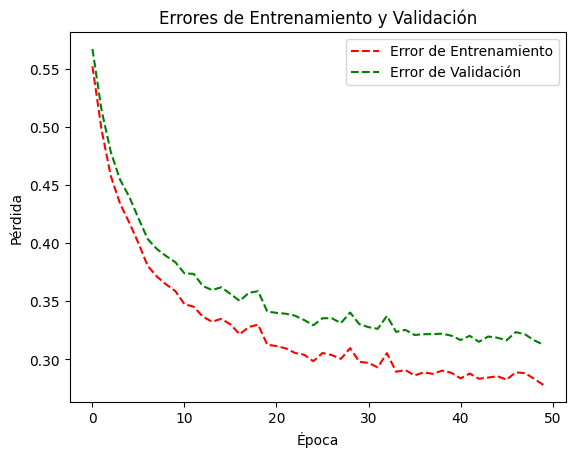

In [ ]:
# 5. Gráfico de errores de entrenamiento y validación
plt.plot(train_losses, label='Error de Entrenamiento', color='red', linestyle='--')
plt.plot(test_losses, label='Error de Validación', color='green', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Errores de Entrenamiento y Validación')
plt.legend()
plt.show()

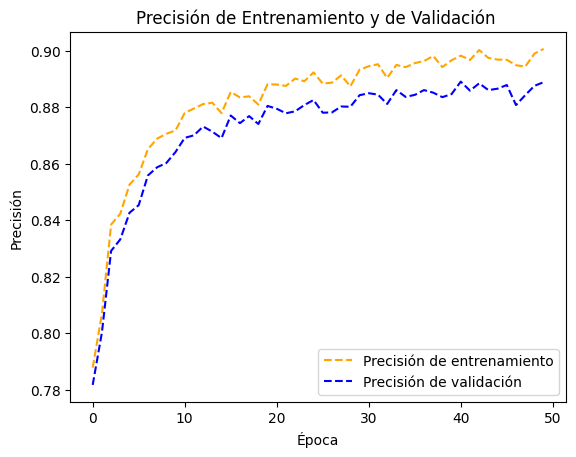

In [ ]:
# 6. Gráfico de precisión
plt.plot(train_accuracies, label='Precisión de entrenamiento', color='orange', linestyle='--')
plt.plot(test_accuracies, label='Precisión de validación', color='blue', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y de Validación ')
plt.legend()
plt.show()

In [ ]:
# 7. Criterio para decidir número de épocas

# Basado en el error
def determinar_numero_epocas_error(error_set, patience=10, min_delta=0.001):
    best_error = error_set[0]
    epochs_without_improvement = 0
    for i, error in enumerate(error_set):
        if error < best_error - min_delta:
            best_error = error
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                return i - patience
    return len(error_set)  # Si no converge en el conjunto, se devuelve el número total de épocas

z, w, y = [determinar_numero_epocas_error(train_losses_incorrecto), determinar_numero_epocas_error(test_losses), determinar_numero_epocas_error(train_losses)]
print(f"Época según error durante el entrenamiento: {z}")
print(f"Época según error de validación: {w}")
print(f"Época según error de entrenamiento: {y}")


# Basado en la precisión
def determinar_numero_epocas_precision(accuracy_set, patience=7):
    best_accuracy = accuracy_set[0]
    epochs_without_improvement = 0
    for i, accuracy in enumerate(accuracy_set):
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                return i - patience
    return len(accuracy_set)  # Si no converge en el conjunto, se devuelve el número total de épocas

w_precision, y_precision = [determinar_numero_epocas_precision(test_accuracies), determinar_numero_epocas_precision(train_accuracies)]
print(f"Época según precisión sobre la validación: {w_precision}")
print(f"Época según precisión sobre el entrenamiento: {y_precision}")


Época según error durante el entrenamiento: 50
Época según error de validación: 50
Época según error de entrenamiento: 50
Época según precisión sobre la validación: 40
Época según precisión sobre el entrenamiento: 50


In [ ]:
# Etiquetas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [ ]:
# Lista para almacenar las predicciones y las etiquetas verdaderas
all_predictions = []
all_labels = []

# Modo evaluación (sin entrenamiento)
clasificador.eval()

# Iterar sobre los datos de validación
for images, labels in valid_loader:  # Utilizando valid_loader en lugar de test_loader
    # Mover datos al dispositivo (por ejemplo, GPU)
    images = images.to(device)
    labels = labels.to(device)

    # Obtener predicciones del clasificador
    with torch.no_grad():
        outputs = clasificador(images)

    # Obtener la clase predicha
    _, predicted = torch.max(outputs, 1)

    # Guardar las predicciones y las etiquetas verdaderas
    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Visualizar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)


Matriz de Confusión:
[[843   1  28  43   4   1  70   0  10   0]
 [  0 973   0  21   1   0   4   0   1   0]
 [ 14   0 861   8  57   0  59   0   1   0]
 [ 12   3  14 917  19   0  34   0   1   0]
 [  1   1  54  45 819   0  79   0   1   0]
 [  0   0   0   0   0 978   0  15   0   7]
 [155   2 100  37  92   0 605   0   9   0]
 [  0   0   0   0   0  11   0 960   0  29]
 [  0   1  10   5   2   5   8   1 968   0]
 [  0   0   0   0   0   6   0  29   1 964]]
